In [1]:
pip install geopandas

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np

from pylab import *
from matplotlib import pyplot as plt

In [3]:
data = pd.read_csv("http://files.zillowstatic.com/research/public_v2/zhvi/Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv")

data.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,...,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,240227.0,238731.0,238811.0,238785.0,239332.0,239996.0,239878.0,240720.0,241086.0,242759.0,244045.0,245658.0,247165.0,250146.0,251834.0,252789.0,253649.0,254553.0,257267.0,257824.0,259519.0,259165.0,261226.0,263922.0,267476.0,270875.0,275198.0,280198.0,284157.0,288330.0,290990.0,...,1331089.0,1320849.0,1315263.0,1312711.0,1309339.0,1311156.0,1301591.0,1286454.0,1272131.0,1261047.0,1273460.0,1286600.0,1307780.0,1314233.0,1326290.0,1329560.0,1343481.0,1345156.0,1352297.0,1347850.0,1340244.0,1353715.0,1362202.0,1382923.0,1373169.0,1369414.0,1352150.0,1335108.0,1304070.0,1278841.0,1263498.0,1258462.0,1255108.0,1237464.0,1213945.0,1184708.0,1172697.0,1163787.0,1161592.0,1163169.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,209848.0,209692.0,209285.0,209150.0,208588.0,208771.0,208559.0,209164.0,210050.0,211557.0,213216.0,214466.0,215928.0,217327.0,219156.0,219911.0,221625.0,222222.0,223504.0,223052.0,221943.0,219941.0,218222.0,217939.0,217960.0,218316.0,218806.0,220247.0,221596.0,223171.0,224882.0,...,488736.0,489965.0,490160.0,489947.0,490902.0,491941.0,491454.0,490213.0,490866.0,495115.0,498121.0,497718.0,496150.0,495913.0,496783.0,496009.0,495385.0,495371.0,496624.0,498166.0,498747.0,496433.0,493491.0,491490.0,491329.0,491842.0,491837.0,492024.0,490921.0,489589.0,488603.0,487610.0,486842.0,486758.0,487956.0,489569.0,490612.0,490770.0,491112.0,492290.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,247618.0,247670.0,247807.0,248689.0,249972.0,251024.0,251373.0,251477.0,251873.0,252621.0,253625.0,254657.0,256041.0,258005.0,260416.0,262166.0,263659.0,265541.0,268372.0,271316.0,274213.0,276911.0,279877.0,283266.0,286431.0,288672.0,290275.0,291696.0,293191.0,295429.0,298173.0,...,1294369.0,1301861.0,1303995.0,1295700.0,1275589.0,1264217.0,1261868.0,1269173.0,1273340.0,1277938.0,1283745.0,1279066.0,1268433.0,1256301.0,1253033.0,1256277.0,1272199.0,1291902.0,1302395.0,1290010.0,1255195.0,1220622.0,1196331.0,1197859.0,1189856.0,1189919.0,1188618.0,1191863.0,1185420.0,1165715.0,1156671.0,1159676.0,1179068.0,1198812.0,1212277.0,1212462.0,1222241.0,1227790.0,1233483.0,1236976.0
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,200202.0,200450.0,200253.0,199065.0,197929.0,197263.0,198025.0,197713.0,197061.0,196272.0,197172.0,198855.0,201411.0,202653.0,203928.0,206130.0,208584.0,210293.0,209962.0,212103.0,214609.0,216811.0,215880.0,214173.0,211445.0,209837.0,208134.0,207196.0,206159.0,205751.0,205644.0,...,331861.0,330787.0,330497.0,330831.0,331021.0,330881.0,330885.0,330923.0,331858.0,332829.0,333121.0,332875.0,333212.0,334103.0,334798.0,334726.0,335103.0,335456.0,335842.0,336266.0,336112.0,336505.0,336532.0,336580.0,335690.0,334984.0,334768.0,335326.0,335547.0,335782.0,335844.0,335848.0,335952.0,335676.0,335851.0,336272.0,337283.0,338136.0,338624.0,338802.0
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,284312.0,284053.0,283529.0,283386.0,282703.0,282792.0,282295.0,282860.0,283949.0,285903.0,288198.0,290162.

In [4]:
phila = data[data['CountyName'] == "Philadelphia County"]

phila = phila.reset_index()
phila = pd.melt(phila, id_vars='RegionName', value_vars=phila.columns[10:])

phila.columns = ['zip', 'date', 'price']

phila['date'] = pd.to_datetime(phila['date'], format='%Y-%m-%d')
phila['year'] = pd.DatetimeIndex(phila['date']).year

phila.head()

,zip,date,price,year
0,19143,1996-01-31,59483.0,1996
1,19111,1996-01-31,85060.0,1996
2,19124,1996-01-31,45097.0,1996
3,19120,1996-01-31,56639.0,1996
4,19104,1996-01-31,NaN,1996


In [5]:
means = phila.groupby(['year', 'zip']).mean().unstack().droplevel(0, 1)

In [6]:
nums = means.columns.max() - means.columns.min() + 1 
hexs = []

cmap = cm.get_cmap('jet', nums)

for i in range(cmap.N):
    rgb = cmap(i)[:3] 
    hexs.append(matplotlib.colors.rgb2hex(rgb))

In [7]:
zips = gpd.read_file("http://data.phl.opendata.arcgis.com/datasets/b54ec5210cee41c3a884c9086f7af1be_0.geojson")
zips['zip'] = zips['CODE'].astype('int64')

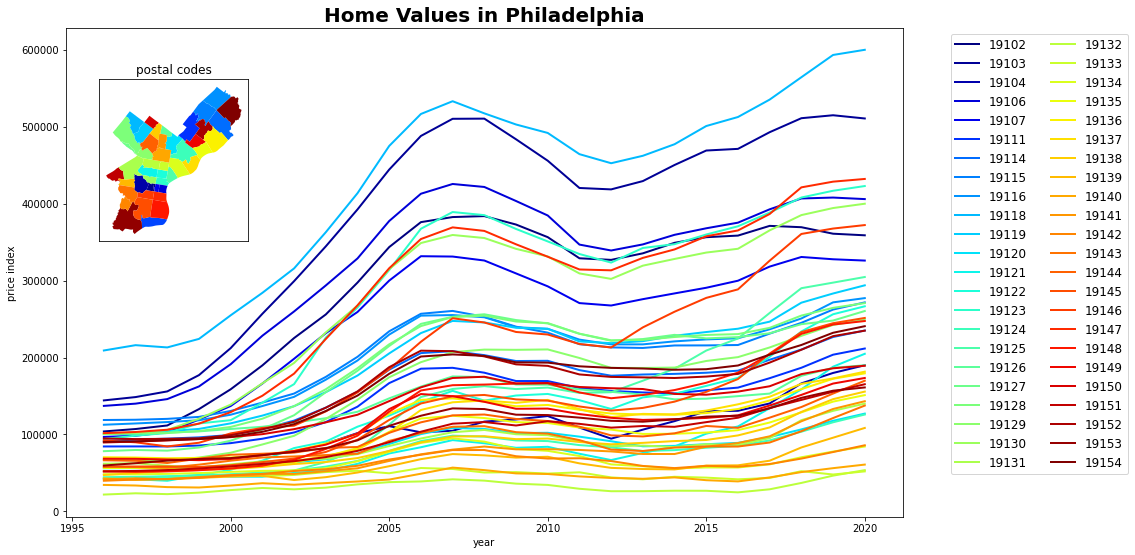

In [8]:
with plt.style.context('fast'):

    fig, ax = plt.subplots(figsize=(15,9))

    plt.title("Home Values in Philadelphia", size=20, weight='bold')

    for zip in means.columns:
        
      ax.plot(means.index, means[zip], label=zip, linewidth=2, c=hexs[zip-means.columns.min()])

    ax.legend(loc=0, ncol=2, fontsize=12, bbox_to_anchor=(1.05, 1))
    
    sub = plt.axes([0.15, 0.55, 0.15, 0.25], facecolor='w')
    zips.plot('zip', ax=sub, cmap='jet')
    plt.xticks([])
    plt.yticks([])
    plt.title('postal codes') 

    ax.set_xlabel("year")
    ax.set_ylabel("price index");

In [9]:
bests = means.reset_index()
bests = pd.melt(bests, id_vars='year', value_vars=bests.columns[1:])

bests.columns = ['year', 'zip', 'price']

years = bests.groupby('year').price.max()

In [10]:
selection = bests['price'].isin(years)
bests.loc[selection]

,year,zip,price
225,1996,19118,209123.416667
226,1997,19118,216023.833333
227,1998,19118,213096.916667
228,1999,19118,224171.666667
229,2000,19118,254821.250000
230,2001,19118,283999.916667
231,2002,19118,315735.083333
232,2003,19118,362736.000000
233,2004,19118,413424.916667
234,2005,19118,474796.833333


In [11]:
means = phila.groupby(['year', 'zip'], as_index=False).mean()

In [12]:
shape = means.merge(zips, left_on="zip", right_on="zip", how='left')
shape = gpd.GeoDataFrame(shape)

Text(0.5, 0.98, 'Home Values in Philadelphia')

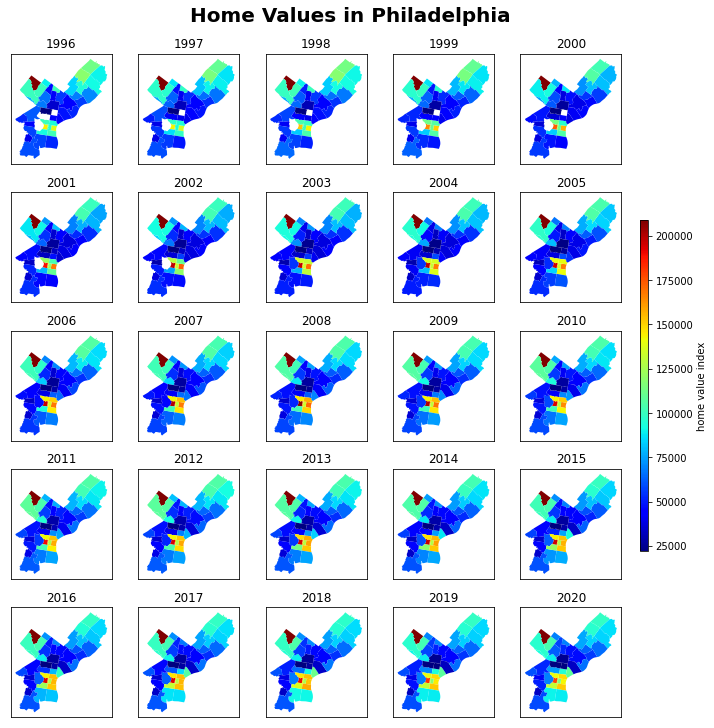

In [13]:
fig, axs = plt.subplots(5,5, figsize=(10,10), 
                        facecolor='w',
                        constrained_layout=True, 
                        sharex=True, sharey=True, 
                        subplot_kw=dict(aspect='equal'))

axs = axs.ravel()

years = shape.year.unique()

for i in np.arange(0, 25):

  year = years[i] 

  axs[i].set_title(year)
  axs[i].set_xticks([])
  axs[i].set_yticks([]) 

  shape[shape['year']==year].plot('price', ax=axs[i], cmap = 'jet')

patch_col = axs[0].collections[0]
cb = fig.colorbar(patch_col, ax=axs, shrink=0.5, label='home value index')

fig.suptitle('Home Values in Philadelphia', size=20, weight='bold')